# TF-IDF Vectorizer 

In [1]:
import os
os.getcwd() 
os.chdir('/Users/hannahz/Desktop/G5055_Practicum_Project2/Data/Text_Model_Data')

In [4]:
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ConnieXu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ConnieXu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
#optional to show 
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [5]:
df = pd.read_excel('definition_filled.xlsx')

In [6]:
#remove \n
df['definition'] = df['definition'].replace(r'\n',' ', regex=True) 
#remove multiple whitespace
df['definition'] = df['definition'].replace('\s+', ' ', regex=True)
#remove white space in the beginning and end
df['definition'] = df['definition'].str.strip()
stop_words_l=stopwords.words('english')
# removing special characters and stop words from the text and lower case (age) - age,  (the - ''
df['definition']=df['definition'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]','',w).lower() not in stop_words_l) )

#remove white space 
df['definition'] = df['definition'].replace('\s+', ' ', regex=True)

In [6]:
#stem
stemmer = SnowballStemmer('english')
stemmer.stem('indicator')
df['definition'] = [" ".join([stemmer.stem(word) for word in sentence.split(" ")]) for sentence in df['definition']]

In [7]:
df['definition']

0      indic proport popul intern poverti line defin ...
1      nation poverti rate percentag total popul live...
2      follow four seri use monitor sdg offici multid...
3      indic reflect proport person effect cover soci...
4      follow key concept defin support indic context...
                             ...                        
241    indic base wbg data amount unit state dollar c...
242    indic refer number countri nation statist legi...
243    indic number countri nation statist plan fulli...
244    indic dollar valu resourc made avail strengthe...
245    indic track proport countri conduct least one ...
Name: definition, Length: 246, dtype: object

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidfvectoriser=TfidfVectorizer()
tfidfvectoriser.fit(df['definition'])
tfidf_vectors=tfidfvectoriser.transform(df['definition'])

#calculate similarity based on the vectors
pairwise_similarities=cosine_similarity(tfidf_vectors.toarray())

In [9]:
def similardocs_one(doc_id,similarity_matrix):
    #find the index for the doc_id
    index = df.iloc[doc_id]['Index']
    #initiated related index
    related_index = []
    similar_score = similarity_matrix[doc_id]
    score_sort = np.sort(similar_score)[::-1]
    #find related doc_id, sort from most similar to least similar 
    similar_ix=np.argsort(similarity_matrix[doc_id])[::-1] # sort doc_id from most similar to least 
    #find corresponded index for doc_id
    for ix in similar_ix:
        if ix==doc_id:
            continue
        related_index.append(df.iloc[ix]["Index"])
    #create a dataframe of
    relation_df = pd.DataFrame({'indicator': np.repeat(index, len(related_index)),
                                'related_indicator': related_index,
                                'similarity_score': score_sort[1:]})
    return relation_df

list_of_dataframes = [similardocs_one(x,pairwise_similarities) for x in range(len(df['Index']))]
outcome = pd.concat(list_of_dataframes)

In [10]:
outcome.shape

(60270, 3)

In [ ]:
# save it to csv
#outcome.to_csv('outcome.csv', index = False)

In [11]:
#choose the threshold of 0.2 and keep all the duplicate pairs
outcome_pair = outcome[outcome['similarity_score'] >= 0.2]
outcome_pair

,indicator,related_indicator,similarity_score
0,1.1.1,1.2.1,0.486675
0,1.2.1,1.1.1,0.486675
0,1.2.2,1.b.1,0.212234
0,1.3.1,17.1.1,0.236192
0,1.4.1,6.2.1,0.375773
...,...,...,...
2,17.18.3,17.18.2,0.245164
3,17.18.3,17.5.1,0.240845
0,17.19.1,17.18.3,0.308272
1,17.19.1,17.18.2,0.228812


In [12]:
most_central_indicator = outcome_pair.groupby(['indicator'])['related_indicator'].count().reset_index(name = 'num_of_relatedindic').sort_values(by = 'num_of_relatedindic',ascending=False)

In [13]:
most_central_indicator = most_central_indicator.reset_index(drop = True)

In [14]:
most_central_indicator

,indicator,num_of_relatedindic
0,17.2.1,14
1,1.a.1,11
2,1.a.2,11
3,5.3.1,10
4,16.2.3,10
...,...,...
191,16.7.2,1
192,16.5.2,1
193,16.4.1,1
194,16.3.3,1


In [19]:
#save it to data 
#most_central_indicator.to_csv('most_central_indicator.csv')

In [23]:
ind17 = outcome_pair[outcome_pair['indicator'] == '17.2.1']
ind17 

,indicator,related_indicator,similarity_score
0,17.2.1,8.a.1,0.396998
1,17.2.1,1.a.1,0.377151
2,17.2.1,6.a.1,0.330725
3,17.2.1,17.12.1,0.298103
4,17.2.1,2.a.2,0.281884
5,17.2.1,17.9.1,0.272766
6,17.2.1,10.b.1,0.270509
7,17.2.1,9.a.1,0.264087
8,17.2.1,4.b.1,0.263449
9,17.2.1,10.a.1,0.244776


In [26]:
#save
#ind17.to_csv('ind17.csv', index=False)

In [45]:
#drop duplicate pair
outcome = outcome.reset_index(drop = True)
outcome_new = outcome.loc[pd.DataFrame(np.sort(outcome[['indicator', 'related_indicator']],1),index=outcome.index).drop_duplicates(keep='first').index]

In [46]:
outcome_new

,indicator,related_indicator,similarity_score
0,1.1.1,1.2.1,0.486675
1,1.1.1,10.2.1,0.196380
2,1.1.1,2.c.1,0.195556
3,1.1.1,16.b.1,0.184231
4,1.1.1,10.3.1,0.184231
...,...,...,...
59291,17.18.2,17.19.1,0.228812
59297,17.18.2,17.19.2,0.109456
59535,17.18.3,17.19.1,0.308272
59557,17.18.3,17.19.2,0.116123


In [ ]:
# save it to csv
#outcome_new.to_csv('outcome_new.csv', index = False)

In [49]:
outcome_nopair = outcome_new[outcome_new['similarity_score'] >= 0.2]
outcome_nopair = outcome_nopair.reset_index(drop = True)

In [50]:
outcome_nopair

,indicator,related_indicator,similarity_score
0,1.1.1,1.2.1,0.486675
1,1.2.2,1.b.1,0.212234
2,1.3.1,17.1.1,0.236192
3,1.4.1,6.2.1,0.375773
4,1.4.1,11.6.1,0.363539
...,...,...,...
347,17.11.1,17.12.1,0.327914
348,17.15.1,17.16.1,0.210638
349,17.18.2,17.18.3,0.245164
350,17.18.2,17.19.1,0.228812


In [53]:
#save
#outcome_nopair.to_csv('edgelist.csv',index = False)

## Similarity Scores - Distributions 

/Users/ConnieXu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


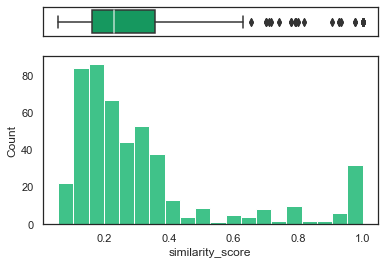

In [72]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="white")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(top2["similarity_score"], ax=ax_box, color = '#00AE62', medianprops=dict(color="white", alpha=0.7))
sns.histplot(data=top2, x="similarity_score", ax=ax_hist, color = '#00AE62')
ax_box.set(xlabel='')

# col = "grey"
# for i,artist in enumerate(ax_box.artists):
#     #col = lighten_color(artist.get_facecolor(), 1.2)
#     artist.set_edgecolor(col)    

#     # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
#     # Loop over them here, and use the same colour as above
#     for j in range(i*6,i*6+6):
#         line = ax_box.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)
#         line.set_linewidth(0.5)   # ADDITIONAL ADJUSTMENT
        
plt.show()

Here it looks like the 50th percentile for top 2 observations is 0.2, meaning that this could be a resaonable threshold to cut off for particularly linked variables. The boxplot shows the 25-75th percentils of 'top 2' linked indicators on average seem to range between 0.15 and 0.35. 

In [80]:
df

Index  \
0      1.1.1   
1      1.2.1   
2      1.2.2   
3      1.3.1   
4      1.4.1   
5      1.4.2   
6      1.5.1   
7      1.5.2   
8      1.5.3   
9      1.5.4   
10     1.a.1   
11     1.a.2   
12     1.b.1   
13     2.1.1   
14     2.1.2   
15     2.2.1   
16     2.2.2   
17     2.2.3   
18     2.3.1   
19     2.3.2   
20     2.4.1   
21     2.5.1   
22     2.5.2   
23     2.a.1   
24     2.a.2   
25     2.b.1   
26     2.c.1   
27     3.1.1   
28     3.1.2   
29     3.2.1   
30     3.2.2   
31     3.3.1   
32     3.3.2   
33     3.3.3   
34     3.3.4   
35     3.3.5   
36     3.4.1   
37     3.4.2   
38     3.5.1   
39     3.5.2   
40     3.6.1   
41     3.7.1   
42     3.7.2   
43     3.8.1   
44     3.8.2   
45     3.9.1   
46     3.9.2   
47     3.9.3   
48     3.a.1   
49     3.b.1   
50     3.b.2   
51     3.b.3   
52     3.c.1   
53     3.d.1   
54     3.d.2   
55     4.1.1   
56     4.1.2   
57     4.2.1   
58     4.2.2   
59     4.3.1   
60     4.4.1   
61     4.5.1   
62     4.6.1   
63     4.7.1   
64     4.a.1   
65     4.b.1   
66     4.c.1   
67     5.1.1   
68     5.2.1   
69     5.2.2   
70     5.3.1   
71     5.3.2   
72     5.4.1   
73     5.5.1   
74     5.5.2   
75     5.6.1   
76     5.6.2   
77     5.a.1   
78     5.a.2   
79     5.b.1   
80     5.c.1   
81     6.1.1   
82     6.2.1   
83     6.3.1   
84     6.3.2   
85     6.4.1   
86     6.4.2   
87     6.5.1   
88     6.5.2   
89     6.6.1   
90     6.a.1   
91     6.b.1   
92     7.1.1   
93     7.1.2   
94     7.2.1   
95     7.3.1   
96     7.a.1   
97     7.b.1   
98     8.1.1   
99     8.2.1   
100    8.3.1   
101    8.4.1   
102    8.4.2   
103    8.5.1   
104    8.5.2   
105    8.6.1   
106    8.7.1   
107    8.8.1   
108    8.8.2   
109    8.9.1   
110   8.10.1   
111   8.10.2   
112    8.a.1   
113    8.b.1   
114    9.1.1   
115    9.1.2   
116    9.2.1   
117    9.2.2   
118    9.3.1   
119    9.3.2   
120    9.4.1   
121    9.5.1   
122    9.5.2   
123    9.a.1   
124    9.b.1   
125    9.c.1   
126   10.1.1   
127   10.2.1   
128   10.3.1   
129   10.4.1   
130   10.4.2   
131   10.5.1   
132   10.6.1   
133   10.7.1   
134   10.7.2   
135   10.7.3   
136   10.7.4   
137   10.a.1   
138   10.b.1   
139   10.c.1   
140   11.1.1   
141   11.2.1   
142   11.3.1   
143   11.3.2   
144   11.4.1   
145   11.5.1   
146   11.5.2   
147   11.6.1   
148   11.6.2   
149   11.7.1   
150   11.7.2   
151   11.a.1   
152   11.b.1   
153   11.b.2   
154   12.1.1   
155   12.2.1   
156   12.2.2   
157   12.3.1   
158   12.4.1   
159   12.4.2   
160   12.5.1   
161   12.6.1   
162   12.7.1   
163   12.8.1   
164   12.a.1   
165   12.b.1   
166   12.c.1   
167   13.1.1   
168   13.1.2   
169   13.1.3   
170   13.2.1   
171   13.2.2   
172   13.3.1   
173   13.a.1   
174   13.b.1   
175   14.1.1   
176   14.2.1   
177   14.3.1   
178   14.4.1   
179   14.5.1   
180   14.6.1   
181   14.7.1   
182   14.a.1   
183   14.b.1   
184   14.c.1   
185   15.1.1   
186   15.1.2   
187   15.2.1   
188   15.3.1   
189   15.4.1   
190   15.4.2   
191   15.5.1   
192   15.6.1   
193   15.7.1   
194   15.8.1   
195   15.9.1   
196   15.a.1   
197   15.b.1   
198   15.c.1   
199   16.1.1   
200   16.1.2   
201   16.1.3   
202   16.1.4   
203   16.2.1   
204   16.2.2   
205   16.2.3   
206   16.3.1   
207   16.3.2   
208   16.3.3   
209   16.4.1   
210   16.4.2   
211   16.5.1   
212   16.5.2   
213   16.6.1   
214   16.6.2   
215   16.7.1   
216   16.7.2   
217   16.8.1   
218   16.9.1   
219  16.10.1   
220  16.10.2   
221   16.a.1   
222   16.b.1   
223   17.1.1   
224   17.1.2   
225   17.2.1   
226   17.3.1   
227   17.3.2   
228   17.4.1   
229   17.5.1   
230   17.6.1   
231   17.7.1   
232   17.8.1   
233   17.9.1   
234  17.10.1   
235  17.11.1   
236  17.12.1   
237  17.13.1   
238  17.14.1   
239  17.15.1   
240  17.16.1   
241  17.17.1   
242  17.18.2   
243  17.18.3   
244  17.19.1   
245  17.19.2   

                                                      

/Users/ConnieXu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


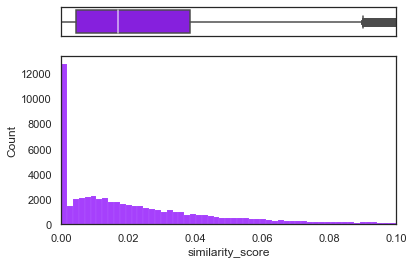

In [93]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(outcome["similarity_score"], ax=ax_box, color = '#8900FC', medianprops=dict(color="white", alpha=0.7))
sns.histplot(data=outcome, x="similarity_score", ax=ax_hist, color = '#8900FC')
ax_box.set(xlabel='')
ax_box.set_xlim(0,0.1)
ax_hist.set_xlim(0,0.1)

# col = "grey"
# for i,artist in enumerate(ax_box.artists):
#     #col = lighten_color(artist.get_facecolor(), 1.2)
#     artist.set_edgecolor(col)    

#     # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
#     # Loop over them here, and use the same colour as above
#     for j in range(i*6,i*6+6):
#         line = ax_box.lines[j]
#         line.set_color(col)
#         line.set_mfc(col)
#         line.set_mec(col)
#         line.set_linewidth(0.5)   # ADDITIONAL ADJUSTMENT
        
plt.show()

In [103]:
print('median {}'.format(outcome["similarity_score"].median()))
print('85th percentile {}'.format(outcome["similarity_score"].quantile(0.85))) 
print('90th percentile {}'.format(outcome["similarity_score"].quantile(0.90)))

median 0.0170603139433646
85th percentile 0.05614725357149454
90th percentile 0.07273537395356755
